In [1]:
import kagglehub
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import IntegerType, DoubleType, StringType, TimestampType, StructType, StructField
from pyspark.ml.feature import StandardScaler, VectorAssembler, PCA, OneHotEncoder
from pyspark.ml.clustering import KMeans
import pyspark.sql.functions as F
from pyspark.ml.functions import vector_to_array
import os
from enum import StrEnum
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from PredictiveMaintenance.Models import Aggregation

In [2]:
path = kagglehub.dataset_download("nphantawee/pump-sensor-data")

In [3]:
# this is a switch to activate some visualization for debugging.
# notice that copies the data to the driver and might slow down the evaluation
# if you use online setups.
VISUALIZATION: bool = True
# how many plots to compare
VISUALIZATION_NUMBER: int = 5

In [4]:
FILE_NAME: str = "sensor.csv"
MACHINE_STATUS: str = "machine_status"
TIMESTAMP: str = "timestamp"
NULL_CUTOFF: float = 0.05  # if a sensor has more Nulls than that, it is ignored
CONSTANT_LIMIT: float = 0.0001  # sensors lower than this std will be ignored
PCA_DATA_PRESERVE: float = 0.99  # how much data variance is preserved

BATCH_SIZE: int = 32
SEQUENCE_LENGTH = 40

# for the different states of the machines, we cluster the data
K_MEANS_SEED: int = 42
K_MEANS_CLUSTER: int = 5
K_MEANS_COLUMN_NAME: str = "kmeans_features"
K_MEANS_CLUSTER_NAME: str = "cluster_id"
K_MEANS_ONE_HOT_NAME: str = "cluster_onehot"

In [5]:
class Status(StrEnum):
    NORMAL = "NORMAL"
    BROKEN = "BROKEN"
    RECOVERING = "RECOVERING"


colors = {
    Status.NORMAL: "green",
    Status.BROKEN: "red",
    Status.RECOVERING: "yellow"
}

In [6]:
# crete Spark session

spark_session = (
    SparkSession.builder
    .appName("PumpSensorData")
    .config("spark.memory.offHeap.enabled", "true")
    .config("spark.memory.offHeap.size", "10g")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/21 14:48:41 WARN Utils: Your hostname, laptop, resolves to a loopback address: 127.0.1.1; using 192.168.178.43 instead (on interface wlp2s0)
25/10/21 14:48:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/21 14:48:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
scheme_list = [
    StructField("", IntegerType(), False),
    StructField(TIMESTAMP, TimestampType(), False)
]
for sensor_index in range(0, 52):
    scheme_list.append(StructField(
        f"sensor_{sensor_index:02d}",
        DoubleType(),
        False)
    )
scheme_list.append(StructField(MACHINE_STATUS, StringType(), False))

scheme: StructType = StructType(scheme_list)

In [8]:
csv_path: str = os.path.join(path, FILE_NAME)
assert os.path.isfile(csv_path)

In [9]:
df: DataFrame = (
    spark_session.read.option("multiline", "false").csv(
        csv_path,
        header=True,
        schema=scheme
    )
).orderBy(F.col(TIMESTAMP))

total_rows = df.count()

# cleanup sensors
# Sensors with no response values
null_ratios = df.agg(*[
    (F.count(F.when(F.col(c).isNull(), c)) / F.lit(total_rows)).alias(c)
    for c in [f"sensor_{i:02d}" for i in range(52)]
]).first()

null_sensors = [c for c in [f"sensor_{i:02d}" for i in range(52)]
                if null_ratios[c] < NULL_CUTOFF]

# constant sensors
constant_sensors_agg = (
    df.agg(*[
        F.stddev(F.col(c)).alias(c) for c in null_sensors
    ])
).first()

sensors = [c for c in null_sensors if (constant_sensors_agg[c] > CONSTANT_LIMIT)]

medians = {c: df.approxQuantile(c, [0.5], 0.001)[0] for c in sensors}
df = df.fillna(medians)

df_normal = df.where(F.col(MACHINE_STATUS) == Status.NORMAL)
df_broken = df.where(F.col(MACHINE_STATUS) == Status.BROKEN)
df_recovering = df.where(F.col(MACHINE_STATUS) == Status.RECOVERING)

mean_values = {}
sensor_diff = {}

for status_name, df_status in [(Status.NORMAL, df_normal), (Status.BROKEN, df_broken), (Status.RECOVERING, df_recovering)]:
    mean_row = df_status.agg(*[F.mean(c).alias(c) for c in sensors]).first()
    mean_values[status_name] = {c: mean_row[c] for c in sensors}

for c in sensors:
    values = [mean_values[status][c] for status in [Status.NORMAL, Status.BROKEN]]
    sensor_diff[c] = max(values) - min(values)

25/10/21 14:48:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

/tmp/ipykernel_54420/1670566501.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


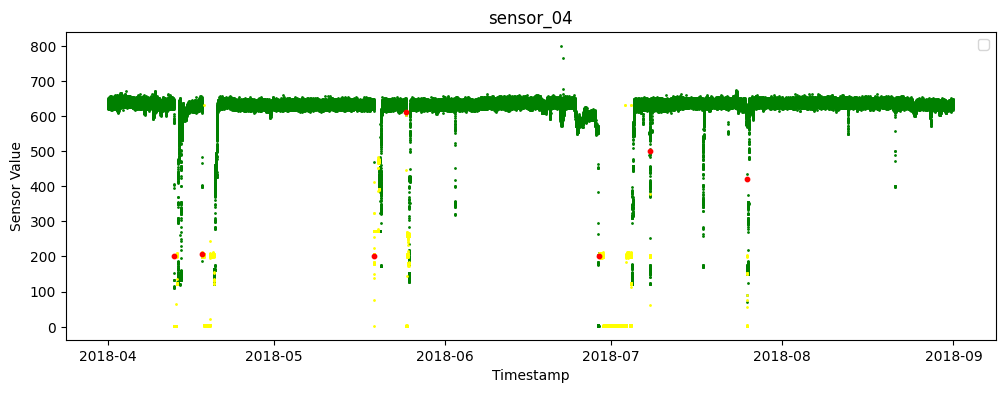

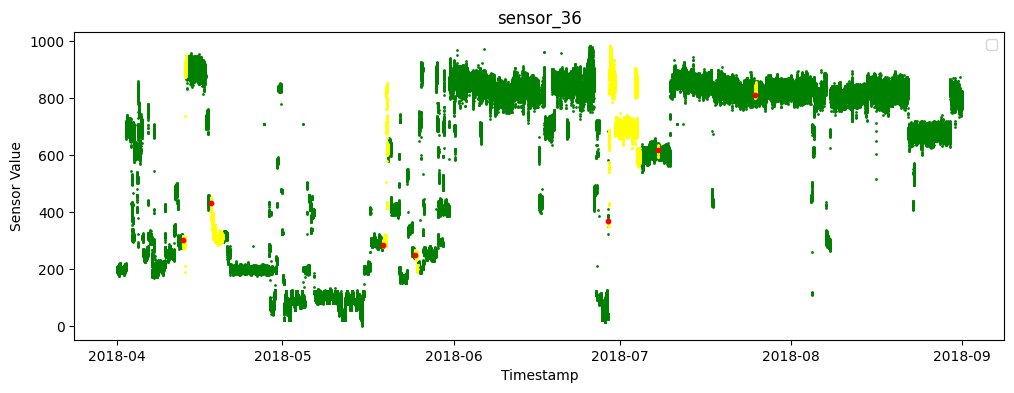

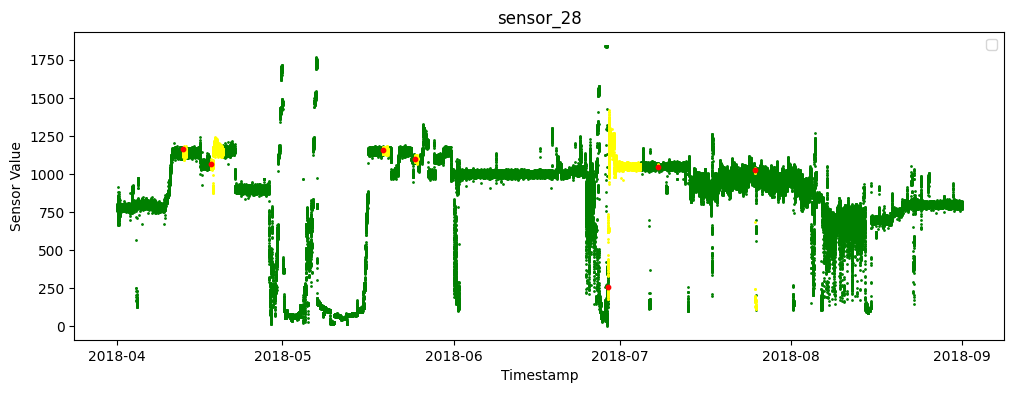

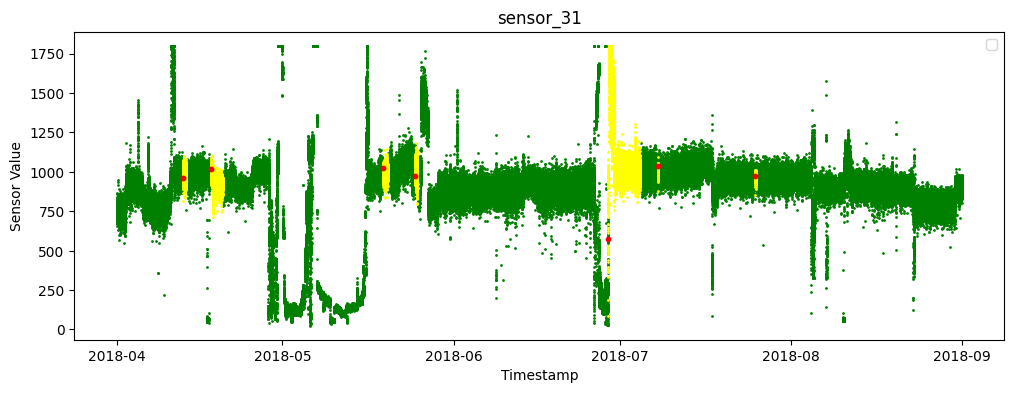

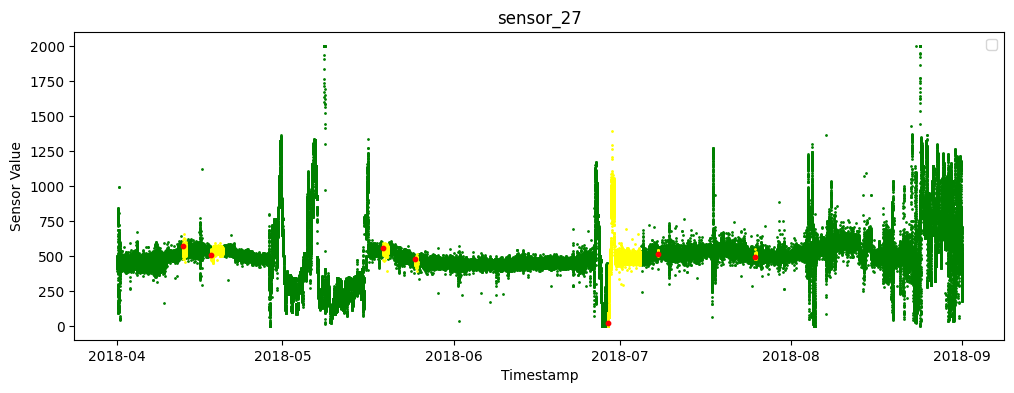

In [10]:
if VISUALIZATION:
    top_sensors = sorted(sensor_diff, key=sensor_diff.get, reverse=True)[:VISUALIZATION_NUMBER]
    df_plot = pd.concat([
        df_normal.select([TIMESTAMP] + top_sensors).toPandas().assign(Status=Status.NORMAL),
        df_broken.select([TIMESTAMP] + top_sensors).toPandas().assign(Status=Status.BROKEN),
        df_recovering.select([TIMESTAMP] + top_sensors).toPandas().assign(Status=Status.RECOVERING)
    ])

    for sensor in top_sensors:
        plt.figure(figsize=(12, 4))
        for status in [Status.NORMAL, Status.RECOVERING, Status.BROKEN]:
            group = df_plot[df_plot["Status"] == status]
            marker_size = 10 if status == Status.BROKEN else 1
            plt.scatter(group[TIMESTAMP], group[sensor], color=colors[status], s=marker_size)

        plt.title(sensor)
        plt.xlabel("Timestamp")
        plt.ylabel("Sensor Value")
        plt.legend()
        plt.show()

We plot the sensors with the most difference in their mean value between operating normally, recovering, and broken.
Here, we can see that the pump is already in different states though not labeling as such

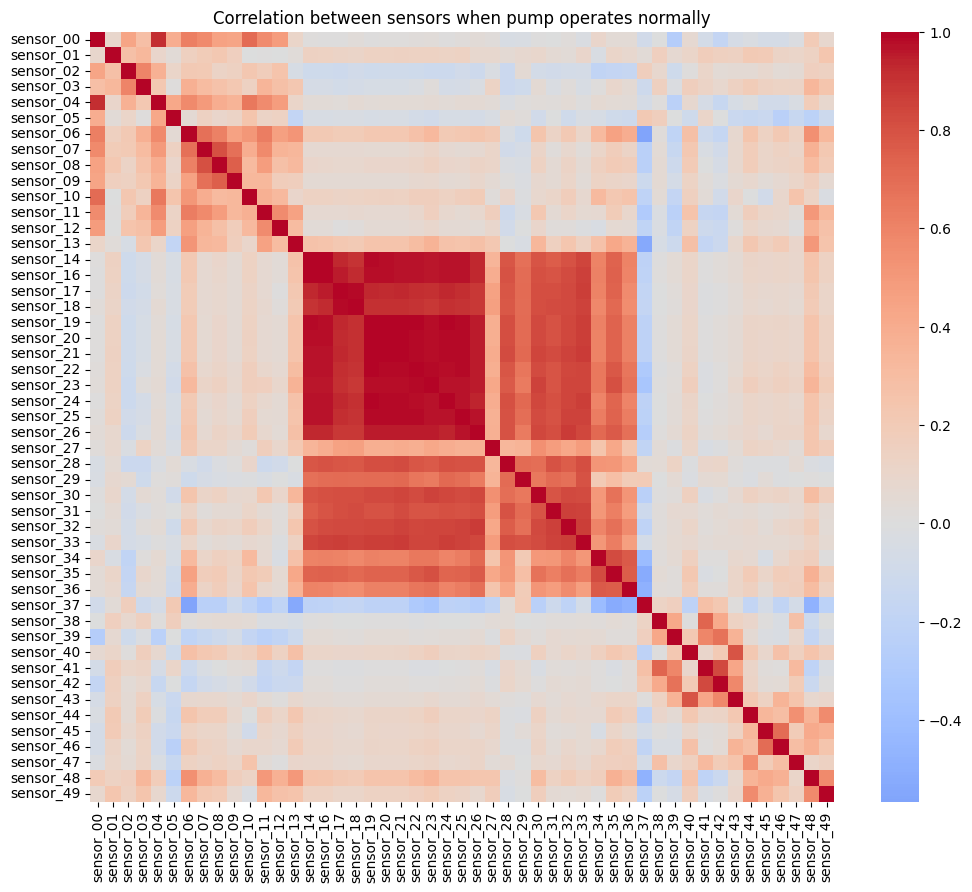

In [11]:
if VISUALIZATION:
    corr = df_normal.toPandas()[sensors].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Correlation between sensors when pump operates normally")
    plt.show()

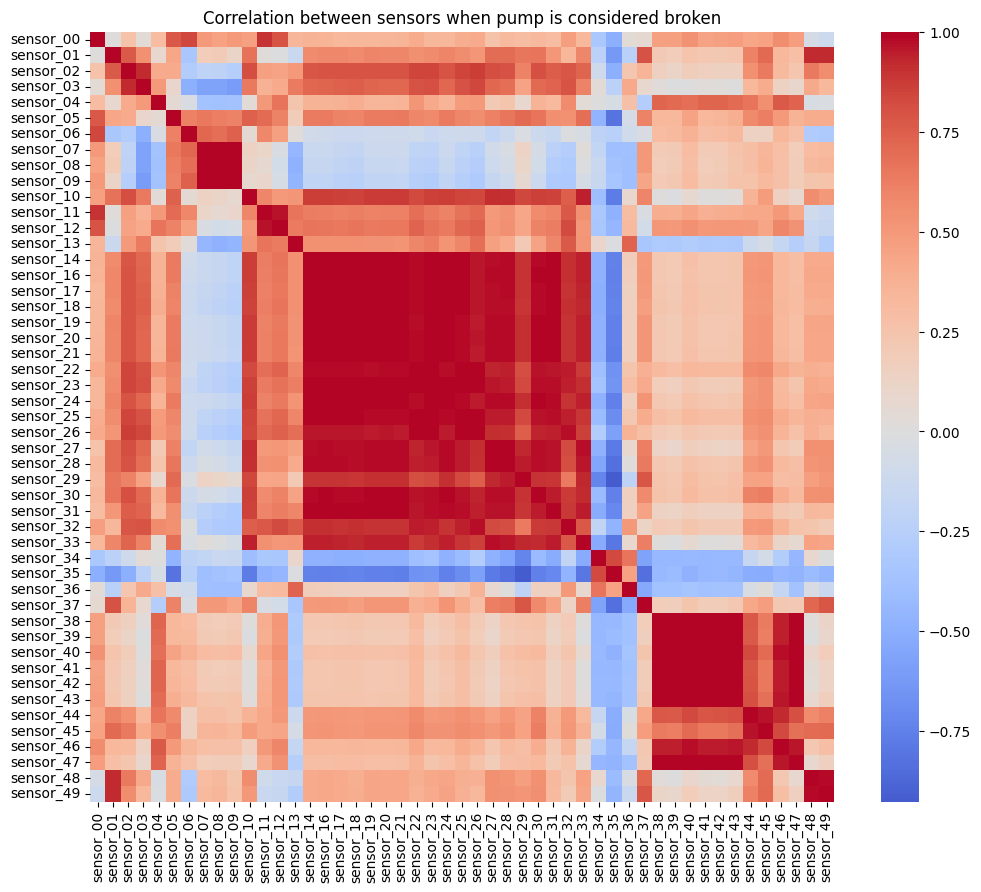

In [12]:
if VISUALIZATION:
    corr = df_broken.toPandas()[sensors].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Correlation between sensors when pump is considered broken")
    plt.show()

The data shows strong correlation, especially in the center of the data.
That means, we can reduce the data using a PCA while maintaining a lot of information.

In comparison between the normal and broken data, we see a big change in the correlation.
We will discuss this difference after the normalization again.

Following, we use a PCA for feature reduction.
We preserve the majority of information about the normal case distribution for the explanation.

In [13]:
pca_assembler = VectorAssembler(inputCols=sensors, outputCol="features")
df_normal_vec = pca_assembler.transform(df_normal)
df_vec = pca_assembler.transform(df)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(df_normal_vec)
df_scaled_normal = scaler_model.transform(df_normal_vec)
pca_full = PCA(k=len(sensors), inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_full_model = pca_full.fit(df_scaled_normal)

n_features = 0
information_content = 0.0
while information_content < PCA_DATA_PRESERVE and n_features < len(sensors):
    information_content += pca_full_model.explainedVariance[n_features]
    n_features += 1

pca = PCA(k=n_features, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(df_scaled_normal)

df_scaled = scaler_model.transform(df_vec)
df_total = pca_model.transform(df_scaled)

In [14]:
# get the full sequence and note it down
time_span = df.agg(
    F.min(F.col(TIMESTAMP)).alias("min_time"),
    F.max(F.col(TIMESTAMP)).alias("max_time")
).first()
min_time = time_span["min_time"]
max_time = time_span["max_time"]
print(f"Measurements are performed from {min_time} to {max_time}")

Measurements are performed from 2018-04-01 00:00:00 to 2018-08-31 23:59:00


In [15]:
# get the sampling frequency for later interpolation
df_prev = df.withColumn("prev",
                        F.lag(TIMESTAMP).over(Window.partitionBy(MACHINE_STATUS).orderBy(TIMESTAMP))
                        )
df_diff = df_prev.withColumn("dt", (F.col(TIMESTAMP).cast("long")
                                    - F.col("prev").cast("long")))
min_dt = df_diff.agg(F.min("dt")).first()[0]
sampling_frequency = 1 / min_dt
print(f"Measureing every {min_dt} seconds ({sampling_frequency} samples per second)")

Measureing every 60 seconds (0.016666666666666666 samples per second)


We add K-Means Clustering to the features: the data shows different states, so we will definitely add those to our database next to the PCA.

In [16]:
kmeans_assembler = VectorAssembler(
    inputCols=sensors,
    outputCol=K_MEANS_COLUMN_NAME
)
df_knn = kmeans_assembler.transform(df_normal)
kmeans = (
    KMeans().setK(K_MEANS_CLUSTER)
        .setSeed(K_MEANS_SEED)
        .setFeaturesCol(K_MEANS_COLUMN_NAME)
        .setPredictionCol(K_MEANS_CLUSTER_NAME)
)
kmeans_model = kmeans.fit(df_knn)
df_total = kmeans_assembler.transform(df_total)
df_total = kmeans_model.transform(df_total)

# here, it doesn't matter that we use all the data available, the clusters are
# fitted and all information is encoded.
one_hot_encoder = OneHotEncoder(
    inputCols=[K_MEANS_CLUSTER_NAME],
    outputCols=[K_MEANS_ONE_HOT_NAME]
)

df_total = one_hot_encoder.fit(df_total).transform(df_total)

# make sure that the sets contain all the prepared information
df_normal = df_total.where(F.col(MACHINE_STATUS) == Status.NORMAL)
df_broken = df_total.where(F.col(MACHINE_STATUS) == Status.BROKEN)
df_recovering = df_total.where(F.col(MACHINE_STATUS) == Status.RECOVERING)

## Data Generator
We use a data generator here for good measure.
That way, we can scale the system up for bigger data sets, SQL servers, data lakes, and so forth.

In [17]:
def get_interval(
    data_frame: DataFrame,
    start_time: datetime,
    end_time: datetime,
    dt: timedelta
) -> tuple[pd.DataFrame, pd.Series, list[str]]:
    segment_spark: DataFrame = (
        data_frame.where((F.col(TIMESTAMP) >= F.lit(start_time)) & (F.col(TIMESTAMP) <= F.lit(end_time)))
            .select(TIMESTAMP, "pcaFeatures", MACHINE_STATUS, K_MEANS_ONE_HOT_NAME)
    )
    df_array = (
        segment_spark
            .withColumn("pca_array", vector_to_array("pcaFeatures"))
            .withColumn("one_hot_array", vector_to_array(K_MEANS_ONE_HOT_NAME))
    )
    n_components: int = df_array.selectExpr("size(pca_array) as n").first()["n"]
    df_flat: DataFrame = df_array.select(
        TIMESTAMP,
        MACHINE_STATUS,
        *[F.col("pca_array")[i].alias(f"pca_{i:02d}") for i in range(0, n_components)],
        *[F.col(K_MEANS_ONE_HOT_NAME)[i].alias(f"cluster_{i:02d}") for i in range(0, K_MEANS_CLUSTER)]
    )
    segment: pd.DataFrame = df_flat.toPandas().sort_values(TIMESTAMP).set_index(TIMESTAMP)
    full_index = pd.date_range(start=start_time, end=end_time, freq=dt)
    segment = segment.reindex(full_index)
    # those are all float values, we can interpolate them to get continuous data
    numeric_cols = [c for c in segment.columns if c.startswith("pca")]
    cluster_cols = [c for c in segment.columns if c.startswith("cluster")]
    segment[numeric_cols] = segment[numeric_cols].interpolate(method="linear")
    segment[MACHINE_STATUS] = segment[MACHINE_STATUS].ffill()
    for c in cluster_cols:
        segment[c] = segment[c].ffill()

    return segment[numeric_cols + cluster_cols], segment[MACHINE_STATUS], numeric_cols + cluster_cols

In [18]:
def data_generator(data_frame: DataFrame,
                   sp=sampling_frequency,
                   seq_length=SEQUENCE_LENGTH,
                   batch_size=BATCH_SIZE):
    time_delta = timedelta(seconds=1.0/sampling_frequency)
    df_time_span = data_frame.agg(
        F.min(F.col(TIMESTAMP)).alias("min_time"),
        F.max(F.col(TIMESTAMP)).alias("max_time")
    ).first()
    df_min_time: datetime = df_time_span["min_time"]
    df_max_time: datetime = df_time_span["max_time"]
    seq_start: datetime = df_min_time
    seq_end: datetime = df_min_time + time_delta * seq_length
    buffer = []
    while seq_end < df_max_time:
        interval, labels, data_cols = get_interval(data_frame, seq_start, seq_end, time_delta)
        seq_start += time_delta
        seq_end += time_delta
        # we ignore the labels for now
        np_array = interval[data_cols].to_numpy()
        buffer.append(np_array)
        if len(buffer) >= batch_size:
            yield np.stack(buffer)
            buffer.clear()

    if buffer:
        yield np.stack(buffer)